## Opening docs

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
import string
import os
import networkx as nx
import codecs
from os import path

In [3]:
# %load ../../utils/read_data.py
import networkx as nx
import codecs
import os
from os import path

def get_data_train(data_path='./data/'):
    with open(path.join(data_path, "train.csv"), 'r') as f:
        train_data = f.read().splitlines()

    train_hosts = list()
    y_train = list()
    for row in train_data:
        host, label = row.split(",")
        train_hosts.append(host)
        y_train.append(label.lower())

    # Text data
    # Load the textual content of a set of webpages for each host into the dictionary "data".
    # The encoding parameter is required since the majority of our data is french.
    text = dict()
    text_path = path.join(data_path, 'text/')
    filenames = os.listdir(text_path)

    for filename in filenames:
        try:
            with codecs.open(path.join(text_path, filename), encoding='utf-8') as f:
                text[filename] = f.read().replace("\n", "").lower()
        except:
            with codecs.open(path.join(text_path, filename), encoding='latin-1') as f:
                text[filename] = f.read().replace("\n", "").lower()

    X_train = list()
    for host in train_hosts:
        if host in text:
            X_train.append([host, text[host]])
        else:
            X_train.append([host, ''])

    return X_train, y_train


def get_data_full(data_path='./data/'):
    with open(path.join(data_path, "train.csv"), 'r') as f:
        train_data = f.read().splitlines()
    with open(path.join(data_path, "test.csv"), 'r') as f:
        test_hosts = f.read().splitlines()

    train_hosts = list()
    y_train = list()
    for row in train_data:
        host, label = row.split(",")
        train_hosts.append(host)
        y_train.append(label.lower())

    # Text data
    # Load the textual content of a set of webpages for each host into the dictionary "data".
    # The encoding parameter is required since the majority of our data is french.
    text = dict()
    text_path = path.join(data_path, 'text/')
    filenames = os.listdir(text_path)

    for filename in filenames:
        try:
            with codecs.open(path.join(text_path, filename), encoding='utf-8') as f:
                text[filename] = f.read().replace("\n", "").lower()
        except:
            with codecs.open(path.join(text_path, filename), encoding='latin-1') as f:
                text[filename] = f.read().replace("\n", "").lower()

    X_train = list()
    for host in train_hosts:
        if host in text:
            X_train.append([host, text[host]])
        else:
            X_train.append([host, ''])
    # Get textual content of web hosts of the test set
    X_test = list()
    for host in test_hosts:
        if host in text:
            X_test.append([host, text[host]])
        else:
            X_test.append([host, ''])
    return X_train, y_train, X_test, test_hosts


In [4]:
X_train, y_train, X_test, test_hosts = get_data_full(data_path='../../data/') 

In [22]:
data_train = pd.DataFrame({'text': X_train,'category': y_train,})
data_train[['train_host','text']] = pd.DataFrame(data_train.text.values.tolist(), index= data_train.index)
data_train.set_index('train_host', inplace=True)
data_train.head()

,text,category
train_host,,
9032,#polepharma » flux polepharma » flux des co...,health/medical
5346,301 moved permanen...,entertainment
18778,(button) fermer en poursuivant votre navi...,entertainment
11939,#hal (button) toggle navigation ccsd ...,education/research
17502,user-agent: * disallow: disallow: /publishe...,tech/science


In [23]:
data_test = pd.DataFrame({'text': X_test,})
data_test[['test_host','text']] = pd.DataFrame(data_test.text.values.tolist(), index= data_test.index)
data_test.set_index('test_host', inplace=True)
data_test.head()

,text
test_host,
27997,iframe: //www.googletagmanager.com/ns.html?...
9316,iframe: https://www.googletagmanager.com/ns...
27045,#toutes les astuces beauté ⋅ astuces beauté...
19805,[logodefault.jpg] [etab_juvisy-sur-orge.p...
26580,#l'école de demain » flux l'école de demain...


In [9]:
labels = ['business/finance', 'education/research', 'entertainment', 'health/medical',
          'news/press', 'politics/government/law', 'sports', 'tech/science']

## Preprocessing

In [38]:
# %load ../../utils/text_preprocessing.py
import numpy as np
import pandas as pd
import re
import string
import os
import networkx as nx
import codecs
from os import path
from bs4 import BeautifulSoup
from string import digits
from nltk.stem.snowball import FrenchStemmer
import nltk
from nltk.corpus import stopwords
import numpy as np
import pickle

nltk.download('wordnet')
import spacy

### Remove html tags and uris from contents
uri_re = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'

def strip_tags_and_uris(x):
    if x:
        # BeautifulSoup on content
        soup = BeautifulSoup(x, "html.parser")
        # Stripping all <code> tags with their content if any
        if soup.code:
            soup.code.decompose()
        # Get all the text out of the html
        text =  soup.get_text()
        # Returning text stripping out all uris
        return re.sub(uri_re, "", text)
    else:
        return ''

def clean(x):
    # Lowercasing all words
    x = x.lower()
    # Removing non ASCII chars
    x = re.sub(r'[^\x00-\x7f]',r' ',x)
#     x = re.sub(r'ô','o',x)
#     x = re.sub(r'[éêè]','e',x)
    x = re.sub(r'([^a-zéèûôàêô])',' ',x)
    x = re.sub('\n', '',x)
    x = re.sub("(\s+.\s+)", ' ', x)#remove any single charecters hanging between 2 spaces

    # Removing (replacing with empty spaces actually) all the punctuations
    return re.sub("["+string.punctuation+"]", " ", x)

stops = set(stopwords.words('french'))
def remove_stopwords(x):
    # Removing all the stopwords
    filtered_words = [word for word in x.split() if word not in stops]
    return " ".join(filtered_words)

def remove_digits(x):
    rm_digits = str.maketrans('', '', digits)
    res = x.translate(rm_digits)
    return res

def remove_non_alpha(x):
    filtered_words = [word for word in x.split() if word.isalpha()]
    return " ".join(filtered_words)

nlp = spacy.load('fr', disable=['parser', 'ner'])
nlp.max_length = 10000000
lemmas_to_keep = ['NOUN', 'PROPN', 'VERB', 'ADJ']
def lemmatize(x):
    doc = nlp(x)
    lemmas = ' '.join(token.lemma_ for token in doc if token.pos_ in lemmas_to_keep)
    return lemmas

def full_preprocessing(df, filename):
    try:
        return pd.read_csv(filename)
    except:
        text = df["text"]
        text = text.map(strip_tags_and_uris)
        text = text.map(clean)
        text = text.map(remove_stopwords)
        text = text.map(remove_non_alpha)
        text = text.map(lemmatize)
        df["text"] = text
        df.to_csv(filename)
    return df

[nltk_data] Downloading package wordnet to /home/elyes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
data_train = full_preprocessing(data_train, 'train_clean.csv.zip')
data_test = full_preprocessing(data_test, 'test_clean.csv.zip')

## TF-IDF + Word2Vec for doc embeddings

In [1]:
!pip3 install unidecode
# !wget http://embeddings.net/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin
!wget http://embeddings.net/frWac_no_postag_no_phrase_500_skip_cut100.bin

  Using cached https://files.pythonhosted.org/packages/d0/42/d9edfed04228bacea2d824904cae367ee9efd05e6cce7ceaaedd0b0ad964/Unidecode-1.1.1-py2.py3-none-any.whl
--2020-02-12 16:43:25--  http://embeddings.net/frWac_no_postag_no_phrase_500_skip_cut100.bin
Resolving embeddings.net (embeddings.net)... 46.17.175.19
Connecting to embeddings.net (embeddings.net)|46.17.175.19|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239625990 (229M) [application/octet-stream]
Saving to: ‘frWac_no_postag_no_phrase_500_skip_cut100.bin’

frWac_no_postag_no_ 100%[===================>] 228.52M  2.21MB/s    in 1m 56s  

2020-02-12 16:45:21 (1.98 MB/s) - ‘frWac_no_postag_no_phrase_500_skip_cut100.bin’ saved [239625990/239625990]



In [2]:
import gensim
from unidecode import unidecode
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize

# wv_from_bin = KeyedVectors.load_word2vec_format('frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin', binary=True)
wv_from_bin = KeyedVectors.load_word2vec_format('frWac_no_postag_no_phrase_500_skip_cut100.bin', binary=True)

In [ ]:
data_train.rename(columns={'train_host': 'host'}, inplace=True)
data_test.rename(columns={'test_host': 'host'}, inplace=True)
data_all = pd.concat([data_train[['host', 'text']], data_test[['host', 'text']]], ignore_index=False)
data_all.set_index('host', inplace=True)
data_all.fillna('', inplace=True)

In [ ]:
#Attention, on a des NaN dans les textes
data_train[data_train.isnull().values]

In [ ]:
data_test[data_test.isnull().values]

In [3]:
wv_from_bin["sommes"]

array([-0.27885148,  1.4402225 ,  0.3878091 ,  0.5499751 ,  1.0356766 ,
       -0.665615  , -0.91227424, -0.03919879, -0.5777326 ,  0.88210106,
       -0.69261515, -0.10831352, -0.4293271 ,  0.13849516, -0.35887718,
        0.4945166 ,  1.0521551 , -0.43297562, -0.23116507,  0.47283012,
       -0.67659676,  0.12309601,  0.07934126,  0.31882057, -1.1215628 ,
        0.04845409, -0.27688408, -0.46135095,  0.06501197, -0.81977254,
        0.11335801, -0.8350754 , -1.0815133 , -1.3473152 , -1.1249847 ,
       -0.4370998 ,  0.1506656 , -0.13085753, -0.61453265,  0.2639501 ,
       -0.04563208,  0.41600555,  0.22868875,  0.20953846, -1.5142282 ,
        0.05854088,  0.22026904, -0.9127829 ,  0.04090389, -0.12525737,
        0.53210586,  0.32718444, -0.20481227, -1.0238289 , -0.42477313,
        0.7035782 ,  0.21971285, -0.73262626,  1.9909254 , -0.9284227 ,
       -0.1883095 , -1.097982  ,  0.70539045,  0.68113166,  0.02001082,
        0.53265023, -0.43142903,  0.5931424 , -0.33113503, -0.19

In [6]:
dataset = [v[0] for v in data_all[['text']].values]
print('a')
dataset_tokenized = [word_tokenize(doc, language='french') if len(doc) > 0 else [] for doc in dataset]
print('a')
dct = Dictionary(dataset_tokenized, prune_at=1000000) 
print('a')
corpus = [dct.doc2bow(doc) for doc in dataset_tokenized]
print('a')
model = TfidfModel(corpus)

In [8]:
try:
    doc_embeds = pickle.load(open('doc_embeds_lem.pkl', 'rb'))
except:
    doc_embeds = {}
    # for fn, doc in zip(filenames, corpus):
    for i, row in enumerate(data_all.iterrows()):
        doc_embed = np.zeros(500)
        doc = corpus[i]
        doc_tfidf = model[doc]
        l = 1
        for word_id, freq in doc_tfidf:
            try:
                word = dct[word_id]
                if len(word) > 1:
                    word_embed = wv_from_bin[dct[word_id]]
                    doc_embed += freq * word_embed
                    l += 1
            except:
                pass
        # doc_embeds.append(doc_embed / l)
        doc_embeds[row[0]] = doc_embed / l
    pickle.dump(doc_embeds, open('doc_embeds_lem.pkl', 'wb'))

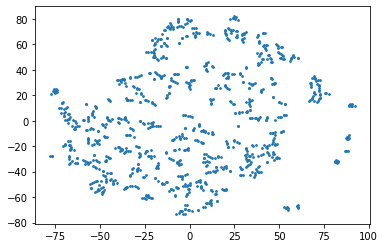

In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

my_pca = PCA(n_components=10)
my_tsne = TSNE(n_components=2, perplexity=5)

my_pca_fit = my_pca.fit_transform(doc_embeds)
my_tsne_fit = my_tsne.fit_transform(my_pca_fit)

plt.scatter(my_tsne_fit[:, 0], my_tsne_fit[:, 1],s=3) ### fill the gap ###

In [3]:
"l'bête".isalpha()

False